# Customer Churn Prediction - EDA and Feature Engineering
## Industry-Standard Data Analysis Pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load and Inspect Data

In [2]:
df = pd.read_csv('../data/telco_churn.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nMemory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
df.head()

Dataset Shape: (7043, 21)

Memory Usage: 1.13 MB


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 2. Data Quality Assessment

In [5]:
# Missing values
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Percentage', ascending=False))

Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []


In [6]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check unique values for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nCategorical columns: {len(categorical_cols)}")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

Duplicate rows: 0

Categorical columns: 18
customerID: 7043 unique values
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


## 3. Target Variable Analysis

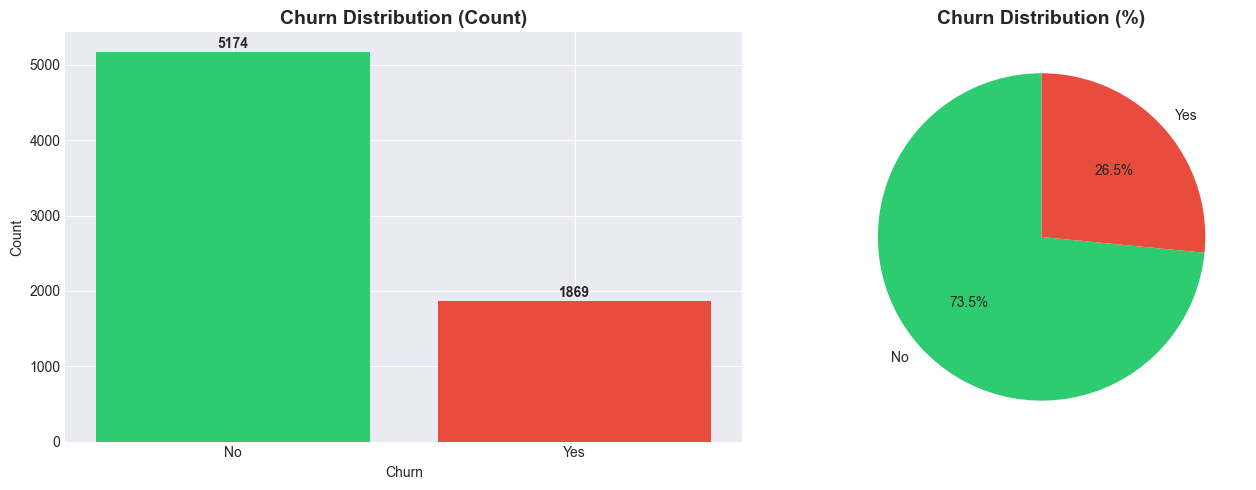

Churn Rate: 26.54%
Class Imbalance Ratio: 2.77:1


In [7]:
# Churn distribution
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(churn_counts.index, churn_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Churn Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Count')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

axes[1].pie(churn_pct.values, labels=churn_pct.index, autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Churn Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Churn Rate: {churn_pct['Yes']:.2f}%")
print(f"Class Imbalance Ratio: {churn_counts['No'] / churn_counts['Yes']:.2f}:1")

## 4. Numerical Features Analysis

In [8]:
# Convert TotalCharges to numeric (handle spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing TotalCharges (new customers with 0 tenure)
df['TotalCharges'].fillna(df['MonthlyCharges'], inplace=True)

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.798992
std,24.559481,30.090047,2266.730170
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


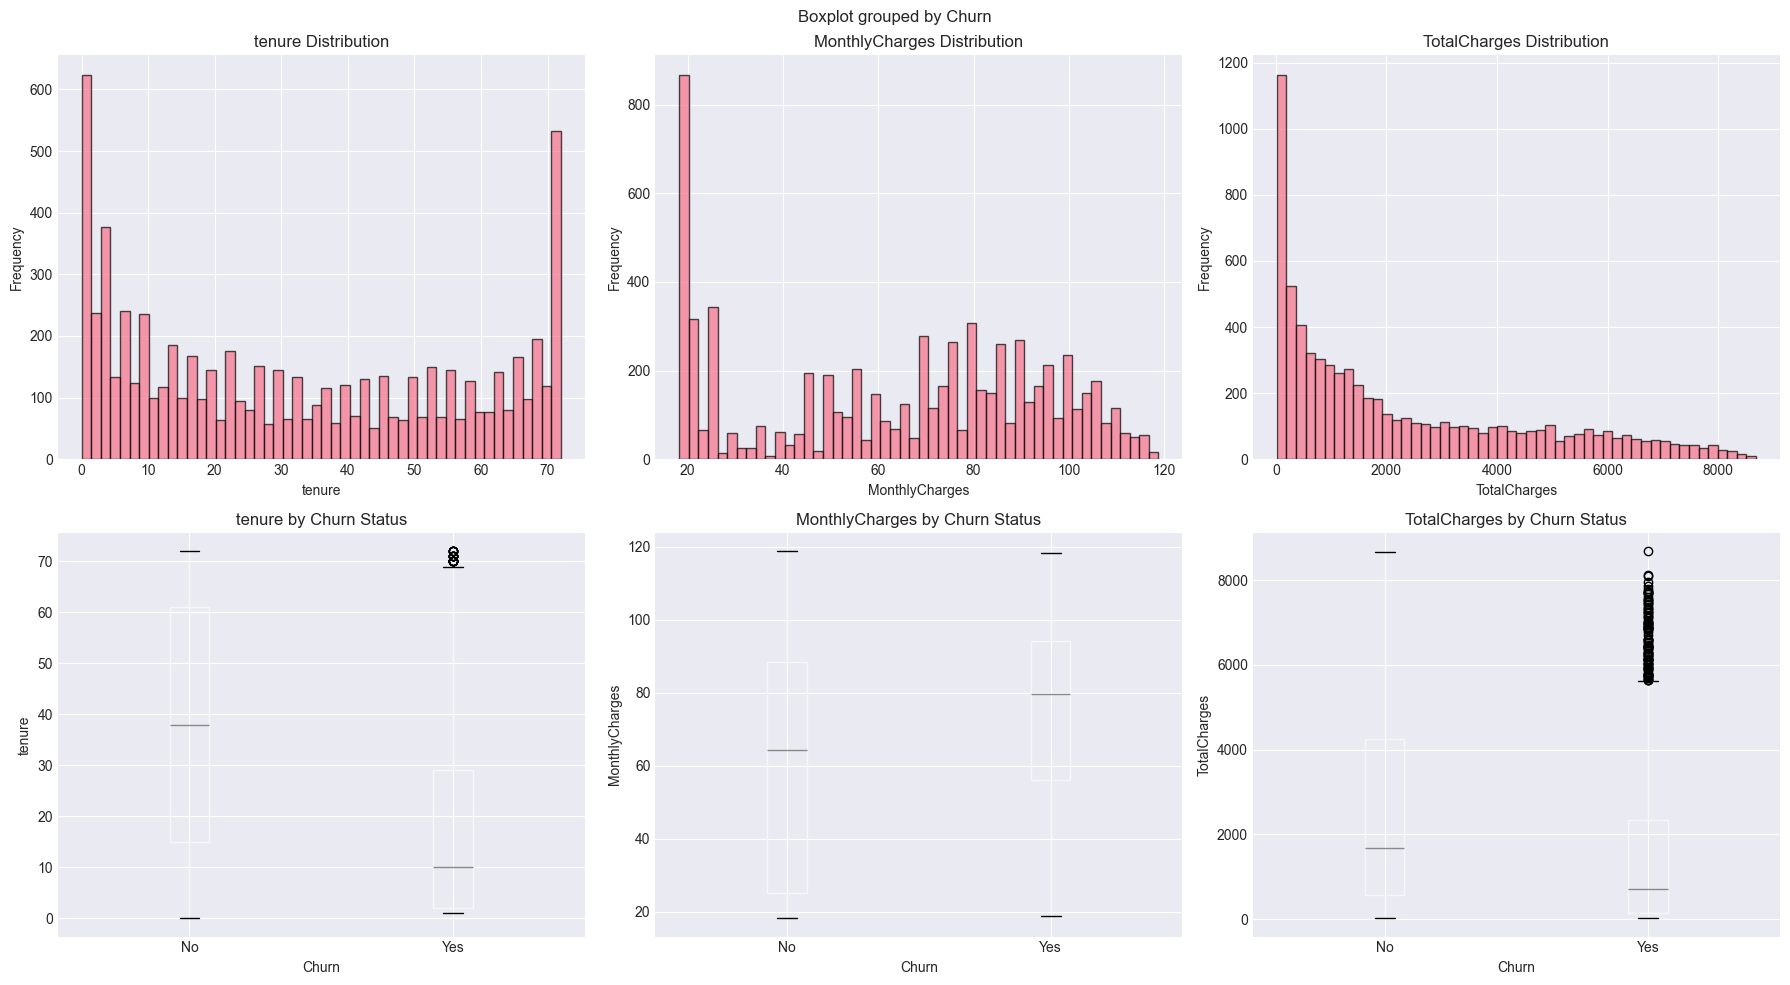

In [9]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Numerical Features Distribution', fontsize=16, fontweight='bold')

for idx, col in enumerate(numerical_cols):
    # Histogram
    axes[0, idx].hist(df[col], bins=50, edgecolor='black', alpha=0.7)
    axes[0, idx].set_title(f'{col} Distribution')
    axes[0, idx].set_xlabel(col)
    axes[0, idx].set_ylabel('Frequency')
    
    # Box plot by Churn
    df.boxplot(column=col, by='Churn', ax=axes[1, idx])
    axes[1, idx].set_title(f'{col} by Churn Status')
    axes[1, idx].set_xlabel('Churn')
    axes[1, idx].set_ylabel(col)

plt.tight_layout()
plt.show()

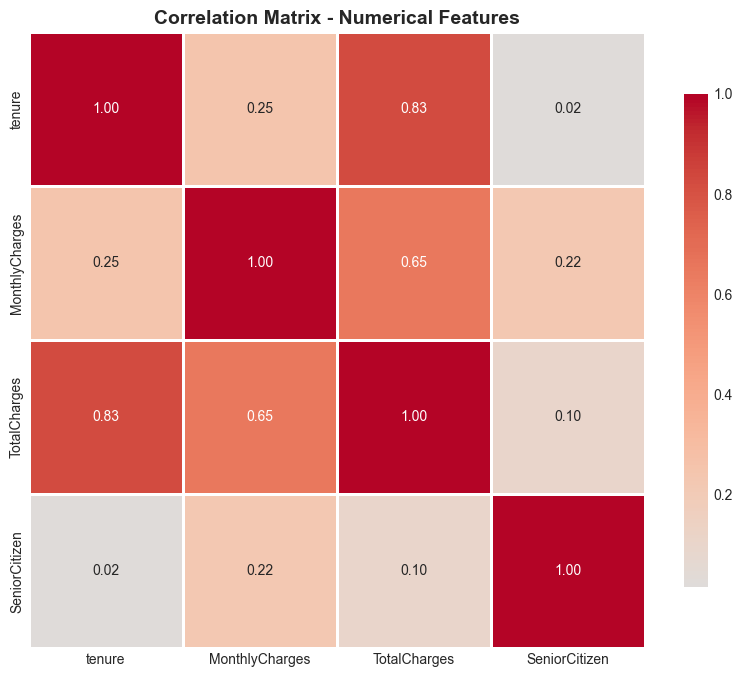

In [10]:
# Correlation analysis
correlation = df[numerical_cols + ['SeniorCitizen']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.show()

## 5. Categorical Features Analysis

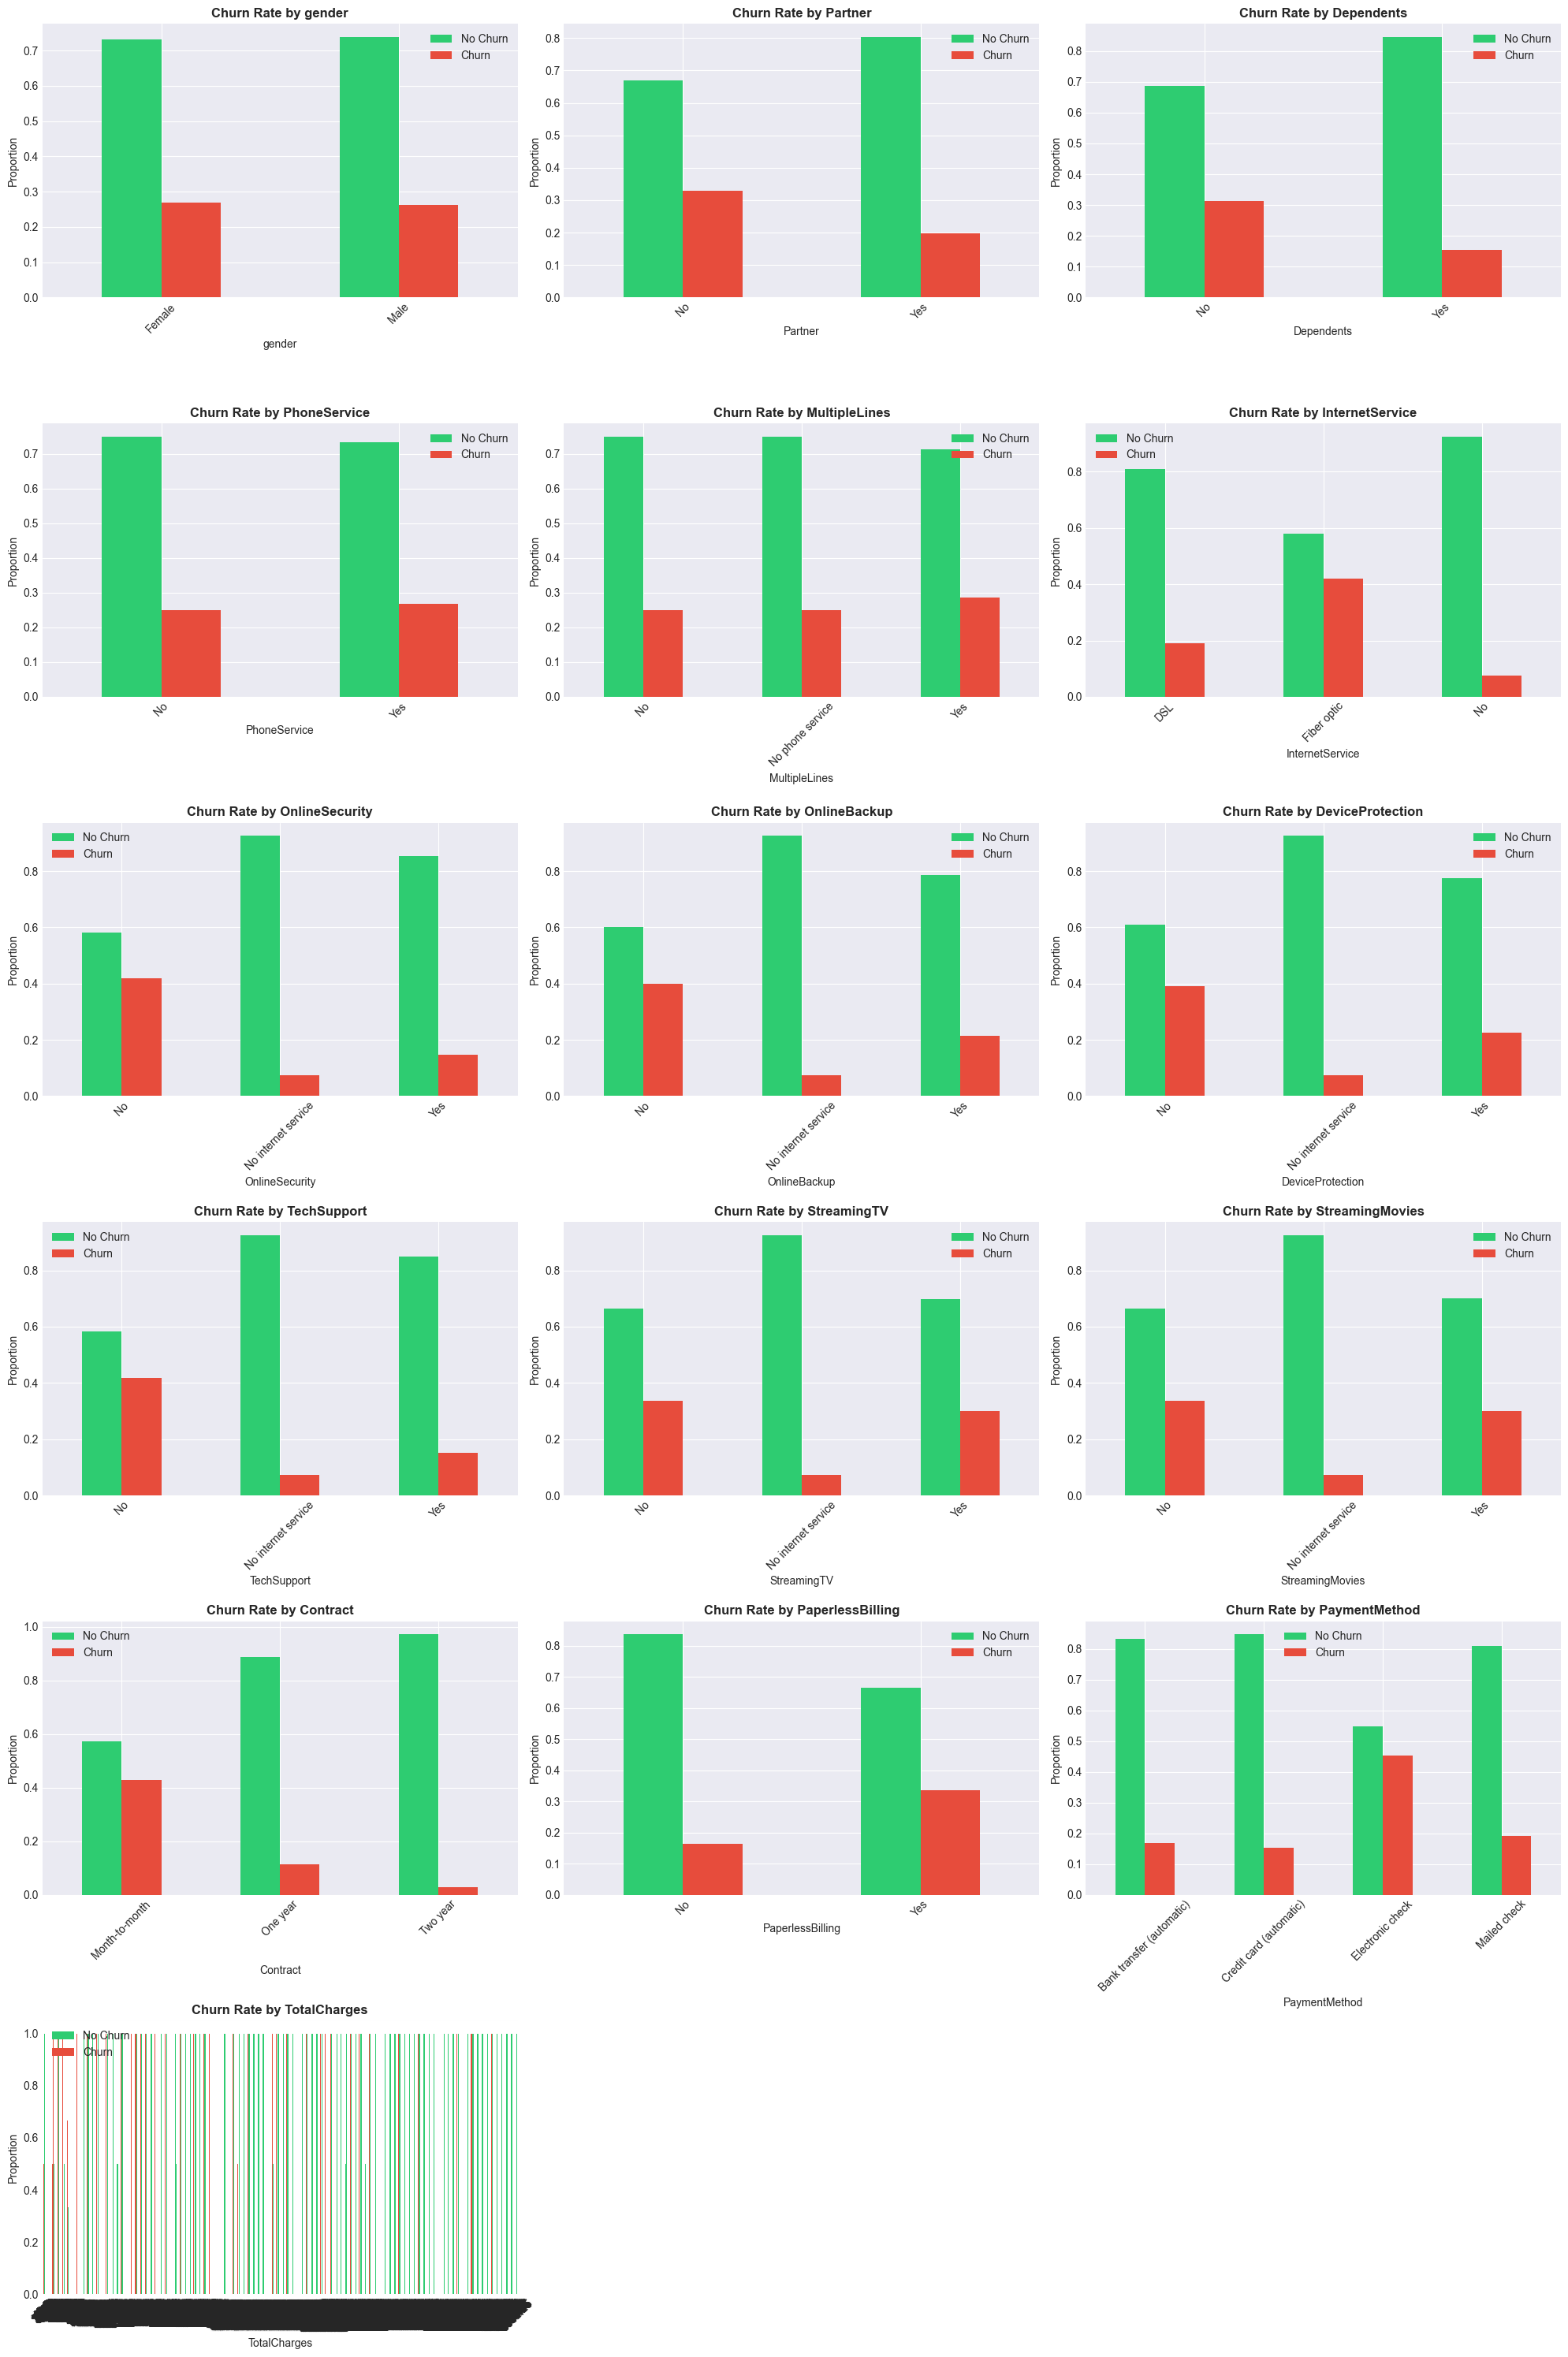

In [11]:
# Exclude customerID and Churn from categorical analysis
cat_features = [col for col in categorical_cols if col not in ['customerID', 'Churn']]

# Plot churn rate by categorical features
n_cols = 3
n_rows = int(np.ceil(len(cat_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(cat_features):
    churn_by_cat = df.groupby(col)['Churn'].value_counts(normalize=True).unstack()
    churn_by_cat.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'Churn Rate by {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Proportion')
    axes[idx].legend(['No Churn', 'Churn'])
    axes[idx].tick_params(axis='x', rotation=45)

# Hide extra subplots
for idx in range(len(cat_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 6. Feature Engineering

In [12]:
# Create a copy for feature engineering
df_fe = df.copy()

# 1. Tenure grouping
df_fe['tenure_group'] = pd.cut(df_fe['tenure'], 
                                bins=[0, 12, 24, 48, 72], 
                                labels=['0-1 year', '1-2 years', '2-4 years', '4+ years'])

# 2. Average monthly charges
df_fe['AvgMonthlyCharges'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)

# 3. Charge increase indicator
df_fe['ChargeIncrease'] = (df_fe['MonthlyCharges'] > df_fe['AvgMonthlyCharges']).astype(int)

# 4. Service combinations
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

df_fe['TotalServices'] = (df_fe[service_cols] == 'Yes').sum(axis=1)

# 5. Contract and payment interaction
df_fe['Contract_Payment'] = df_fe['Contract'] + '_' + df_fe['PaymentMethod']

# 6. Senior citizen with partner
df_fe['SeniorWithPartner'] = ((df_fe['SeniorCitizen'] == 1) & 
                               (df_fe['Partner'] == 'Yes')).astype(int)

# 7. Has any add-on service
addon_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
df_fe['HasAddonService'] = (df_fe[addon_services] == 'Yes').any(axis=1).astype(int)

# 8. Has streaming service
df_fe['HasStreamingService'] = ((df_fe['StreamingTV'] == 'Yes') | 
                                 (df_fe['StreamingMovies'] == 'Yes')).astype(int)

print("New Features Created:")
print(df_fe[['tenure_group', 'AvgMonthlyCharges', 'ChargeIncrease', 
             'TotalServices', 'HasAddonService', 'HasStreamingService']].head())

New Features Created:
  tenure_group  AvgMonthlyCharges  ChargeIncrease  TotalServices  \
0     0-1 year          14.925000               1              1   
1    2-4 years          53.985714               1              3   
2     0-1 year          36.050000               1              3   
3    2-4 years          40.016304               1              3   
4     0-1 year          50.550000               1              1   

   HasAddonService  HasStreamingService  
0                1                    0  
1                1                    0  
2                1                    0  
3                1                    0  
4                0                    0  


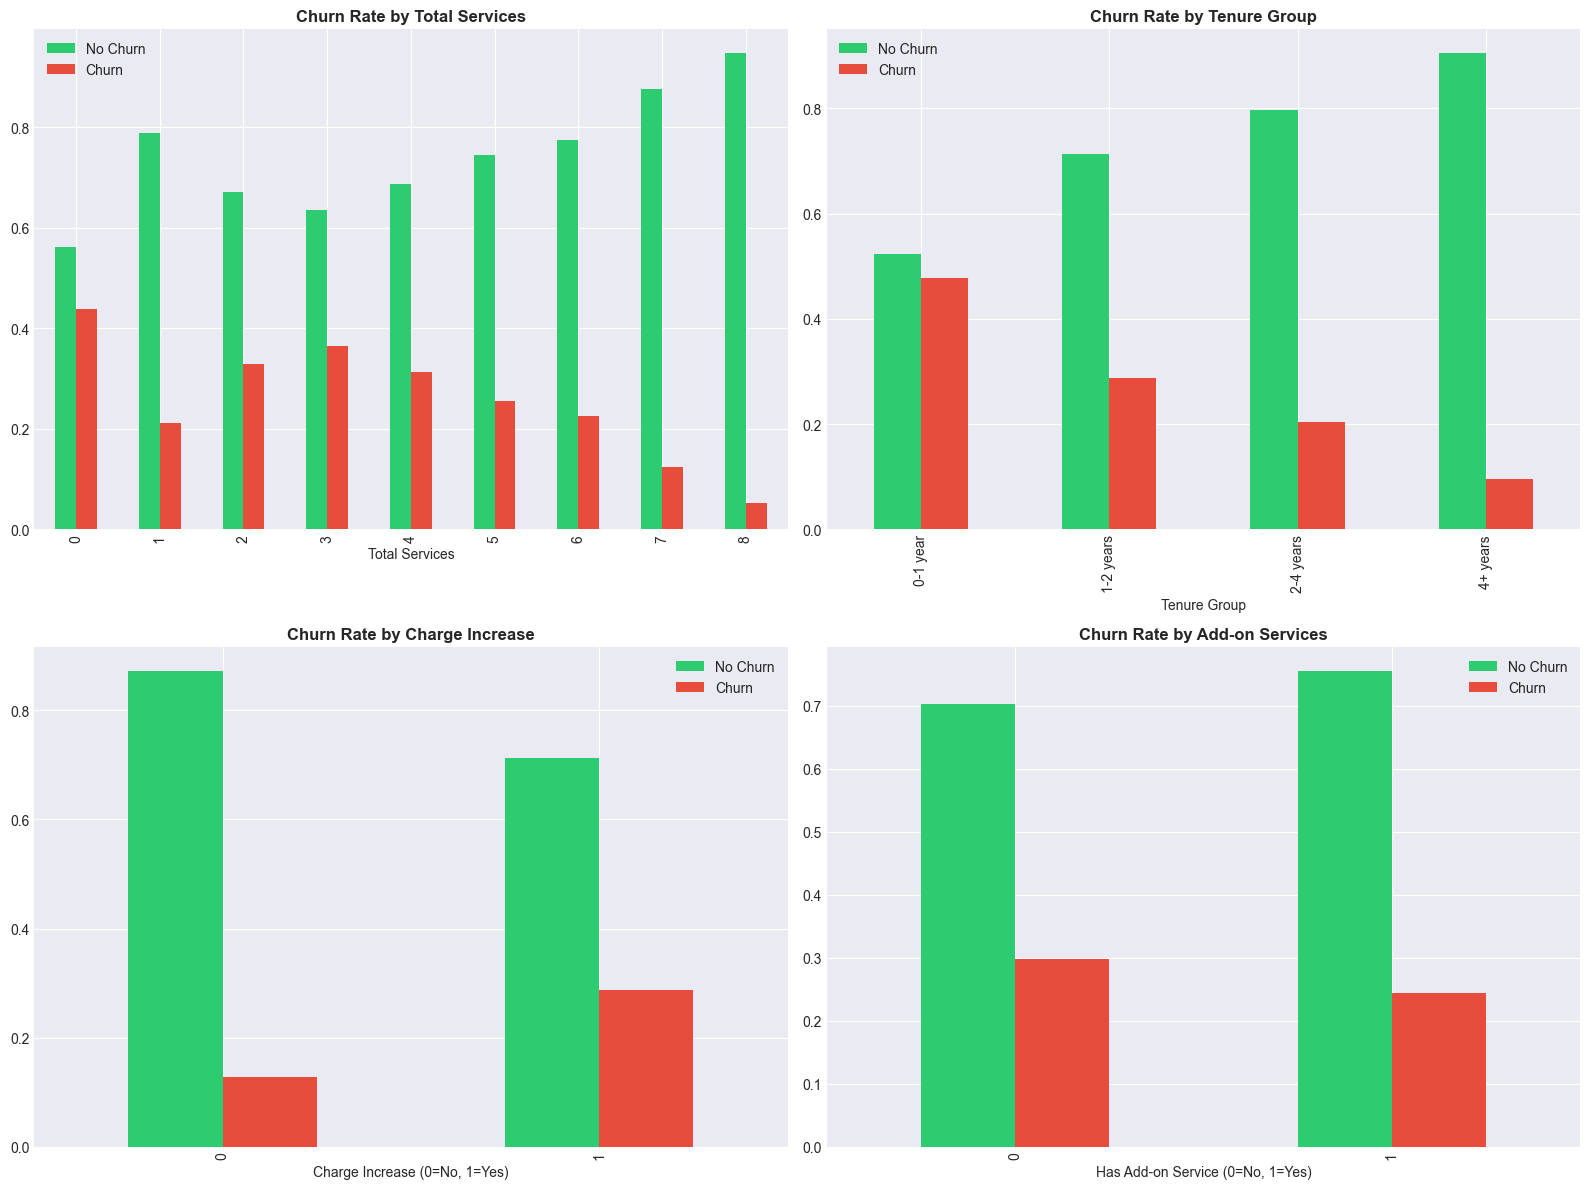

In [13]:
# Analyze new features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total Services
df_fe.groupby('TotalServices')['Churn'].value_counts(normalize=True).unstack().plot(
    kind='bar', ax=axes[0, 0], color=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Churn Rate by Total Services', fontweight='bold')
axes[0, 0].set_xlabel('Total Services')
axes[0, 0].legend(['No Churn', 'Churn'])

# Tenure Group
df_fe.groupby('tenure_group')['Churn'].value_counts(normalize=True).unstack().plot(
    kind='bar', ax=axes[0, 1], color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_title('Churn Rate by Tenure Group', fontweight='bold')
axes[0, 1].set_xlabel('Tenure Group')
axes[0, 1].legend(['No Churn', 'Churn'])

# Charge Increase
df_fe.groupby('ChargeIncrease')['Churn'].value_counts(normalize=True).unstack().plot(
    kind='bar', ax=axes[1, 0], color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_title('Churn Rate by Charge Increase', fontweight='bold')
axes[1, 0].set_xlabel('Charge Increase (0=No, 1=Yes)')
axes[1, 0].legend(['No Churn', 'Churn'])

# Has Addon Service
df_fe.groupby('HasAddonService')['Churn'].value_counts(normalize=True).unstack().plot(
    kind='bar', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'])
axes[1, 1].set_title('Churn Rate by Add-on Services', fontweight='bold')
axes[1, 1].set_xlabel('Has Add-on Service (0=No, 1=Yes)')
axes[1, 1].legend(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()

## 7. Save Processed Data

In [14]:
# Save the feature-engineered dataset
df_fe.to_csv('../data/telco_churn_processed.csv', index=False)
print(f"Processed data saved with shape: {df_fe.shape}")
print(f"New columns added: {set(df_fe.columns) - set(df.columns)}")

Processed data saved with shape: (7043, 29)
New columns added: {'HasAddonService', 'ChargeIncrease', 'SeniorWithPartner', 'AvgMonthlyCharges', 'tenure_group', 'TotalServices', 'HasStreamingService', 'Contract_Payment'}


## 8. Key Insights Summary

### Findings:
1. **Class Imbalance**: Churn rate is approximately 26-27%, indicating moderate imbalance
2. **Tenure**: Strong inverse relationship with churn - longer tenure reduces churn probability
3. **Contract Type**: Month-to-month contracts show highest churn rates
4. **Services**: Customers with fewer services are more likely to churn
5. **Payment Method**: Electronic check users show higher churn rates
6. **Internet Service**: Fiber optic customers have higher churn compared to DSL
7. **Add-on Services**: Lack of security, backup, and support services correlates with higher churn

### Recommendations for Modeling:
- Use SMOTE or class weights to handle imbalance
- Focus on contract type and tenure as strong predictors
- Consider ensemble methods for better performance
- Feature interactions are important (Contract + Payment, Services combination)